Aug 22nd, 2025


Author: Opal Issan (oissan@ucsd.edu)

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz 
import scipy
import math
from QLT_equations.general_plasma_equations import Z_prime, I, Z
from  QLT_equations.dispersion_functions import *

In [3]:
%matplotlib inline
import matplotlib
font = {'family' : 'sans-serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [4]:
# normalization
# time is normalized to the electron cyclotron frequency
# space is normalized to electron inertial length d_e

# match the values in khazanov et al. The nonlinear coupling of electromagnetic ion cyclotron and lower hybrid

# cold electron density
ne = 1  # ne
# cold He+ density
nHe = 0.1  # ne
# cold O+ density
nO = 0.1 # ne
# hot proton density
npH = 0.  # ne
# cold proton density
npC = 1 - npH - nO - nHe  # ne

# mass ratios
mp_me = 1836 # dimensionless
mO_mp = 16  # dimensionless
mHe_mp = 4  # dimensionless

omega_pe = 2 # Omega_ce

# assume the plasma is isothermal Te=Tp=TO+=THe+
alpha_c_perp = np.sqrt(1e-4)  # d_e x Omega_ce
alpha_c_par = alpha_c_perp  # d_e x Omega_ce
alpha_p_par = alpha_c_perp / np.sqrt(mp_me)  # d_e x Omega_ce
alpha_He_par = alpha_c_perp / np.sqrt(mp_me * mHe_mp)  # de x Omega_ce
alpha_O_par = alpha_c_perp / np.sqrt(mp_me * mO_mp)  # de x Omega_ce

wLH = 1/np.sqrt(mp_me) # Omega_ce
rhoe = alpha_c_perp #/np.sqrt(2) # de 

# # relative drift is what matters
# sp=0, vti=8.25123e-05, Ud/vti=2.82843
# sp=1, vti=4.12561e-05, Ud/vti=5.65685
# sp=2, vti=2.06281e-05, Ud/vti=-19.2333

UDp = 2.82843 * alpha_p_par / np.sqrt(2)
UDO = -19.2333 * alpha_O_par / np.sqrt(2)
UDHe = 5.65685 * alpha_He_par /np.sqrt(2)

# dispersion relation 
\begin{align*}
    1 - \frac{2\omega_{pe}^2}{|\vec{k}|^2 \alpha_{\|e}}\left[1 + \sum_{n=-\infty}^{\infty} \exp(-\lambda) I_{n}(\lambda) Z(\xi^{n}_{e}) \xi_{0}^{e} \right]
    = \sum_{s=\{He^{+}, O^{+}, p\}}\frac{\omega_{ps}^2}{\alpha_{\| s}^2 |\vec{k}|^2}  Z' \left( \frac{\omega - k_{\perp} U_{x, Ds}}{\alpha_{\| s} |\vec{k}|}\right).
\end{align*}

Cold approximation:
\begin{align*}
    1 - \frac{\omega_{pe}^2}{\omega^2 }\cos(\theta_{k})^2 + \frac{\omega_{pe}^2}{\Omega_{ce}^2} \sin(\theta_{k})^2
    = \sum_{s=\{He^{+}, O^{+}, p\}}\frac{\omega_{ps}^2}{[\omega - k_{\perp} U_{x, Ds}]^2}.
\end{align*}

In [5]:
def disp_k_(k,
            theta,
            npC_=npC,
            nO_=nO,
            nHe_=nHe,
            omega_pe_=omega_pe,
            mp_me_=mp_me,
            mO_mp_=mO_mp,
            mHe_mp_=mHe_mp,
            VDp_=UDp,
            VDHe_=UDHe,
            VDO_=UDO,
            alpha_c_par_=alpha_c_par,
            alpha_p_par_=alpha_p_par,
            alpha_O_par_=alpha_O_par,
            alpha_He_par_=alpha_He_par, 
            approx="hot"):
    if approx=="hot":
        return lambda omega: 1 + electron_response(k_=k, omega=omega, omega_pe_=omega_pe_, theta_=theta, alpha_c_par_=alpha_c_par_) \
                             - ion_response(omega_pi_=omega_pe_ / np.sqrt(mp_me_), n_=npC_, alpha_i_=alpha_p_par_,
                                            v_0_=VDp_, omega=omega, k_=k, theta_=theta) \
                             - ion_response(omega_pi_=omega_pe_ / np.sqrt(mp_me_ * mO_mp_), n_=nO_,
                                            alpha_i_=alpha_O_par_, k_=k, v_0_=VDO_, omega=omega, theta_=theta) \
                             - ion_response(omega_pi_=omega_pe_ / np.sqrt(mp_me_ * mHe_mp_), n_=nHe_,
                                            alpha_i_=alpha_He_par_, k_=k, v_0_=VDHe_, omega=omega, theta_=theta)
    elif approx=="cold":
        return lambda omega: 1 + electron_response_cold(omega=omega, omega_pe_=omega_pe_, theta_=theta) \
                     - ion_response_cold(omega_pi_=omega_pe_ / np.sqrt(mp_me_), n_=npC_, 
                                    v_0_=VDp_, omega=omega, k_=k, theta_=theta) \
                     - ion_response_cold(omega_pi_=omega_pe_ / np.sqrt(mp_me_ * mO_mp_), n_=nO_,
                                    k_=k, v_0_=VDO_, omega=omega, theta_=theta) \
                     - ion_response_cold(omega_pi_=omega_pe_ / np.sqrt(mp_me_ * mHe_mp_), n_=nHe_,
                                     k_=k, v_0_=VDHe_, omega=omega, theta_=theta)

# Ion-ion current-driven instability 
\begin{equation*}
    k_{\perp} \approx
\frac{\omega_{\mathrm{LH}} \sqrt{c_{cp}}}{U_{x, DO+}}\qquad \mathrm{and} \qquad \omega_{r} = \left[1 - \frac{1}{2^{\frac{4}{3}}} \left[\frac{c_{O+}}{c_{cp}} \frac{m_{p}}{ m_{O+}} \right]^{\frac{1}{3}} \right] \omega_{\mathrm{LH}} \sqrt{c_{cp}}.
\end{equation*}

In [6]:
k_vec =  np.logspace(np.log10(0.2), np.log10(0.5), 100) / rhoe # de
angle = 0
theta_test = -np.pi/2 + angle * np.pi/ 180
omega_guess = np.sqrt(npC) * (1 - 1/(2**(4/3)) * ((nO/npC / mO_mp)**(1/3))) * wLH  # Omega_ce
print("omega_guess = ", omega_guess/wLH)


sol_approx_hot = np.zeros(len(k_vec), dtype="complex128")
sol_approx_cold = np.zeros(len(k_vec), dtype="complex128")

for ii in range(len(k_vec)):
    try:
        sol_approx_hot[ii] = scipy.optimize.newton(disp_k_(k=k_vec[ii], theta=theta_test, approx="hot"), omega_guess + 0.005j, tol=1e-16, 
                                           maxiter=10000, x1=omega_guess*0.99 + 1e-2j)
    except:
        print("hot failed to converge")
    try:
        sol_approx_cold[ii] = scipy.optimize.newton(disp_k_(k=k_vec[ii], theta=theta_test, approx="cold"), omega_guess + 0.005j, tol=1e-16, 
                                           maxiter=10000, x1=omega_guess*0.99 + 1e-2j)
    except:
        print("cold failed to converge")


print("\n[hot] omega_r + i gamma = ", sol_approx_hot/wLH)
print("[hot] dispersion residual = ", abs(disp_k_(k=k_vec, theta=theta_test)(sol_approx_hot)))


print("\n[cold] omega_r + i gamma = ", sol_approx_cold/wLH)
print("[cold] dispersion residual = ", abs(disp_k_(k=k_vec, theta=theta_test)(sol_approx_cold)))

omega_guess =  0.8239954631537199


NameError: name 'k' is not defined

In [ ]:
#plt.plot(k*rhoe, sol_approx_cold.real/wLH)
plt.plot(k*rhoe, sol_approx_cold.imag/wLH)
plt.plot(k*rhoe, sol_approx_hot.imag/wLH)

In [16]:
k_ii = np.abs(np.linspace(0.1, 3, 20) * np.sqrt(npC) * wLH /UDO) # d_e
# k_ii = np.abs(np.logspace(np.log10(0.2), np.log10(0.5), 10) / rhoe)

theta_ii = -np.pi/2 + np.linspace(0, 10, 20)*np.pi/180

sol_ii_cold = np.zeros((len(k_ii), len(theta_ii)), dtype="complex128") * np.nan
sol_ii_hot = np.zeros((len(k_ii), len(theta_ii)), dtype="complex128") * np.nan

In [13]:
for ii in range(len(k_ii)):
    for jj in range(len(theta_ii)):
        try:
            sol_ii_hot[ii, jj] = scipy.optimize.newton(disp_k_(k=k_ii[ii], theta=theta_ii[jj], approx="hot"), 
                                                   omega_guess + 1e-2j, tol=1e-16, maxiter=1000, 
                                                   x1=omega_guess*0.99 + 1e-2j)
            
            error = abs(disp_k_(k=k_ii[ii], theta=theta_ii[jj])(sol_ii_hot[ii, jj]))
            print("dispersion residual hot = ", error)
            if error > 1e-10:
                sol_ii_hot[ii, jj] = np.nan
        except:
            print("An exception occurred")

        try:
            sol_ii_cold[ii, jj] = scipy.optimize.newton(disp_k_(k=k_ii[ii], theta=theta_ii[jj], approx="cold"), 
                                                   omega_guess + 1e-2j, tol=1e-16, maxiter=1000, 
                                                   x1=sol_ii_hot[ii, jj])
            
            error = abs(disp_k_(k=k_ii[ii], theta=theta_ii[jj])(sol_ii_cold[ii, jj]))
            print("dispersion residual cold = ", error)
            if error > 10:
                sol_ii_cold[ii, jj] = np.nan
        except:
            print("An exception occurred")

An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An excepti

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_31831/2805035824.py:23: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_31831/2805035824.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return n_ * (omega_pi_ ** 2) /((omega - k_perp * v_0_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)


An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An excepti

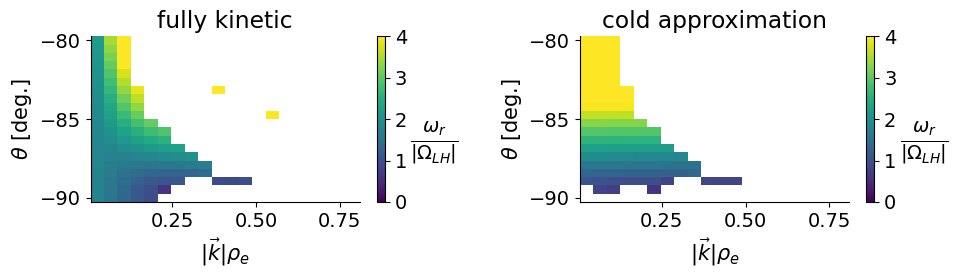

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
pos = ax[0].pcolormesh(k_ii*rhoe, theta_ii*180/np.pi, sol_ii_hot.real.T / wLH, vmin=0, vmax=4)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r'$\frac{\omega_{r}}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax[0].set_xlabel(r'$|\vec{k}|\rho_{e}$', fontsize=15)
ax[0].set_ylabel(r'$\theta$ [deg.]', fontsize=15)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("fully kinetic")

pos = ax[1].pcolormesh(k_ii*rhoe, theta_ii*180/np.pi, sol_ii_cold.real.T / wLH, vmin=0, vmax=4)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r'$\frac{\omega_{r}}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax[1].set_xlabel(r'$|\vec{k}|\rho_{e}$', fontsize=15)
ax[1].set_ylabel(r'$\theta$ [deg.]', fontsize=15)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title("cold approximation")
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
pos = ax[0].contourf(k_ii*rhoe, theta_ii*180/np.pi, sol_ii_hot.imag.T / wLH, vmin=1E-5, vmax=0.2, 
                  levels=np.linspace(1e-5, 0.2, 25))

cbar = fig.colorbar(pos)
cbar.set_ticks([1e-5, 0.1, 0.2])
cbar.set_ticklabels(["$10^{-5}$", "0.1", "0.2"])
cbar.ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax[0].set_xlabel(r'$|\vec{k}|\rho_{e}$', fontsize=15)
ax[0].set_ylabel(r'$\theta$ [deg.]', fontsize=15)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)


pos = ax[1].contourf(k_ii*rhoe, theta_ii*180/np.pi, sol_ii_cold.imag.T / wLH, vmin=1E-5, vmax=0.2, 
                  levels=np.linspace(1e-5, 0.2, 25))

cbar = fig.colorbar(pos)
cbar.set_ticks([1e-5, 0.1, 0.2])
cbar.set_ticklabels(["$10^{-5}$", "0.1", "0.2"])
cbar.ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax[1].set_xlabel(r'$|\vec{k}|\rho_{e}$', fontsize=15)
ax[1].set_ylabel(r'$\theta$ [deg.]', fontsize=15)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.tight_layout()
#plt.savefig("../../figs/vadim_2021/vadim_fig5_a.png", dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(6, 3), sharex=True)
ax[0].plot(k_ii*rhoe, sol_ii_hot.imag[:, 0]/wLH)
ax[1].plot(k_ii*rhoe, sol_ii_hot.real[:, 0]/wLH)
ax[1].set_xlabel(r"$|\vec{k}| \rho_{e}$")
ax[0].set_ylabel(r"$\gamma/\omega_{LH}$")
ax[1].set_ylabel(r"$\omega_{r}/\omega_{LH}$")
ax[0].set_title(r"$\theta = \pi/2$")

In [ ]:
fig, ax = plt.subplots()
for ii in range(len(theta_ii)):
    for jj in range(len(k_ii)):
        k_perp = k_ii[jj] * np.sin(theta_ii[ii])
        k_par = k_ii[jj] * np.cos(theta_ii[ii])
        if sol_ii_hot.imag[jj, ii]/wLH > 1e-3:
            plt.scatter(k_perp*rhoe, k_par*rhoe)

ax.set_xlabel(r"$k_{\perp} \rho_{e}$")
ax.set_ylabel(r"$k_{\|} \rho_{e}$")

# MTSI 

\begin{equation*}
    k_{\perp} = \frac{\omega_{\mathrm{LH}} \sqrt{c_{cp}}}{U_{x, Dp}} \qquad \mathrm{and} \qquad \omega_{r} = \frac{1}{2^{\frac{4}{3}}} \left[\frac{m_{p}}{m_{e}} \sqrt{c_{cp}}\cos^2(\theta_{k})\right]^{\frac{1}{3}} \omega_{\mathrm{LH}}.
\end{equation*}

In [14]:
# relative drift is what matters
UDp = 3 * alpha_p_par
UDO = 0 * alpha_p_par 

In [15]:
# quick check
k = wLH * np.sqrt(npC) / UDp   # d_e
angle = 1
theta = np.pi/2 - angle *np.pi/180


omega_guess = 1/(2**(3/4)) * ((mp_me * np.sqrt(npC)*(np.cos(theta)**2))**(1/3)) *wLH # Omega_ce

print("omega_guess = ", omega_guess/wLH)

sol_approx_hot = scipy.optimize.newton(disp_k_(k=k, theta=theta, approx="hot", VDp_=UDp, VDO_=UDO), omega_guess + 0.005j, tol=1e-16, 
                                   maxiter=1000, x1=omega_guess*1.1 + 1e-2j)

sol_approx_cold = scipy.optimize.newton(disp_k_(k=k, theta=theta, approx="cold", VDp_=UDp, VDO_=UDO), omega_guess + 0.005j, tol=1e-16, 
                                   maxiter=1000, x1=omega_guess*2 + 1e-2j)


print("\n[hot] omega_r + i gamma = ", sol_approx_hot/wLH)
print("[hot] dispersion residual = ", abs(disp_k_(k=k, theta=theta)(sol_approx_hot)))


print("\n[cold] omega_r + i gamma = ", sol_approx_cold/wLH)
print("[cold] dispersion residual = ", abs(disp_k_(k=k, theta=theta)(sol_approx_cold)))

omega_guess =  0.47199450110626273


/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_30604/997708656.py:23: RuntimeWarning: overflow encountered in scalar power
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_30604/997708656.py:23: RuntimeWarning: invalid value encountered in scalar power
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_30604/997708656.py:23: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_30604/997708656.py:27: RuntimeWarning: overflow encountered in scalar power
  return n_ * (omega_pi_ ** 2) /((omega - k_perp * v_0_)**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_30604/997708656.py:27: RuntimeWarning: in

RuntimeError: Failed to converge after 1000 iterations, value is (nan+nanj).

In [ ]:
k_mtsi = np.abs(np.linspace(0.02, 5, 30) * wLH * np.sqrt(npC) / UDp) # d_e
theta_mtsi = np.pi/2 - np.linspace(0, 180, 20)*np.pi/180
sol_mtsi_hot = np.ones((len(k_mtsi), len(theta_mtsi)), dtype="complex128") * np.nan
sol_mtsi_cold = np.ones((len(k_mtsi), len(theta_mtsi)), dtype="complex128") * np.nan

In [ ]:
for ii in range(len(k_mtsi)):
    for jj in range(len(theta_mtsi)):
        try:
            sol_mtsi_hot[ii, jj] = scipy.optimize.newton(disp_k_(k=k_mtsi[ii], theta=theta_mtsi[jj], approx="hot", VDp_=UDp, VDO_=UDO),  
                                                     omega_guess + 0.005j, 
                                                    tol=1e-16, maxiter=1000, 
                                                    x1=omega_guess*2 + 1e-2j)
            
            error = abs(disp_k_(k=k_mtsi[ii], theta=theta_mtsi[jj])(sol_mtsi_hot[ii, jj]))
            print("dispersion residual hot = ", error)
            if error > 1e-8:
                sol_mtsi_hot[ii, jj] = np.nan
        except:
            print("An exception occurred")
        try:
            sol_mtsi_cold[ii, jj] = scipy.optimize.newton(disp_k_(k=k_mtsi[ii], theta=theta_mtsi[jj], approx="cold", VDp_=VDp, VDO_=UDO),  
                                                     omega_guess + 0.005j, 
                                                    tol=1e-16, maxiter=1000, 
                                                    x1=omega_guess*2 + 1e-2j)
            
            error = abs(disp_k_(k=k_mtsi[ii], theta=theta_mtsi[jj])(sol_mtsi_cold[ii, jj]))
            print("dispersion residual cold = ", error)
            if error > 1e-8:
                sol_mtsi_cold[ii, jj] = np.nan
        except:
            print("An exception occurred")

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(k_mtsi*rhoe, theta_mtsi*180/np.pi, sol_mtsi_hot.real.T /wLH)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r'$\frac{\omega_{r}}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax.set_xlabel(r'$k \rho_{e}$', fontsize=15)
ax.set_ylabel(r'$\theta$ [deg.]', fontsize=15)


#ax.set_xticks([180, 200, 220, 240])
#ax.set_xlim(175, 245)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()
# plt.savefig("figures/linear_theory/MTSI/omega_r_VD_" + str(round(UDp/alpha_p_par, 1)) + "_mpme_" + str(round(mp_me))+ ".png", dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))

pos_mtsi = ax.contourf(k_mtsi*rhoe, theta_mtsi_hot*180/np.pi,
                sol_mtsi.imag.T * np.sqrt(mp_me), vmin=1E-5, vmax=0.2, levels=np.linspace(1e-5, 0.2, 15))

cbar = fig.colorbar(pos_mtsi)
cbar.ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax.set_xlabel(r'$|\vec{k}| \rho_{e}$', fontsize=15)
ax.set_ylabel(r'$\theta$ [deg.]', fontsize=15)
cbar.set_ticks([1e-5, 0.1, 0.2])
cbar.set_ticklabels(["$10^{-5}$", "0.1", "0.2"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()

# plt.savefig("figures/linear_theory/MTSI/gamma_VD_" + str(round(UDp/alpha_p_par, 1))  + "_mpme_" + str(round(mp_me))+ ".png", dpi=300, bbox_inches='tight')

# Plot both instabilities 

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))


pos_ii = ax.contourf(k_ii*rhoe, theta_ii*180/np.pi, sol_ii_hot.imag.T / wLH,
                  vmin=1E-5, vmax=0.2, levels=np.linspace(1e-5, 0.2, 15), cmap="plasma")

pos_mtsi = ax.contourf(k_mtsi*rhoe, theta_mtsi*180/np.pi, sol_mtsi.imag.T * np.sqrt(mp_me), 
                       vmin=1E-5, vmax=0.2, levels=np.linspace(1e-5, 0.2, 15), cmap="viridis")

cbar = fig.colorbar(pos_mtsi)
cbar.ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax.set_xlabel(r'$|\vec{k}|\rho_{e}$', fontsize=15)
ax.set_ylabel(r'$\theta$ [deg.]', fontsize=15)
cbar.set_ticks([1e-5, 0.1, 0.2])
cbar.set_ticklabels(["$10^{-5}$", "0.1", "0.2"])


#ax.set_ylim(80, 90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()
